# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report

Данные о клиентах банка:

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

Прочие признаки:

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).



**deposit** - целевая переменная, которая определяет, согласится ли клиент открыть депозит в банке.

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [206]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [207]:
display(df.describe())
display(df.describe(include='object'))
df.info()

age           day      duration      campaign         pdays  \
count  11162.000000  11162.000000  11162.000000  11162.000000  11162.000000   
mean      41.231948     15.658036    371.993818      2.508421     51.330407   
std       11.913369      8.420740    347.128386      2.722077    108.758282   
min       18.000000      1.000000      2.000000      1.000000     -1.000000   
25%       32.000000      8.000000    138.000000      1.000000     -1.000000   
50%       39.000000     15.000000    255.000000      2.000000     -1.000000   
75%       49.000000     22.000000    496.000000      3.000000     20.750000   
max       95.000000     31.000000   3881.000000     63.000000    854.000000   

           previous  
count  11162.000000  
mean       0.832557  
std        2.292007  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max       58.000000

job  marital  education default balance housing   loan  \
count        11162    11162      11162   11162   11137   11162  11162   
unique          12        3          4       2    3802       2      2   
top     management  married  secondary      no   0  $       no     no   
freq          2566     6351       5476   10994     774    5881   9702   

         contact  month poutcome deposit  
count      11162  11162    11162   11162  
unique         3     12        4       2  
top     cellular    may  unknown      no  
freq        8042   2824     8326    5873

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [208]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [209]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df.job.value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [210]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df[~df['balance'].isna()]['balance'].apply(lambda x: float(''.join(x.replace(',','.').strip()[:-1].split())))

### Задание 4

In [211]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df['balance'] = df['balance'].fillna(df.balance.median())

### Задание 5

In [212]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
display(df.education.value_counts())

df['education'] = df['education'].replace({'unknown':df.education.mode()[0]})
df['job'] = df['job'].replace({'unknown':df.job.mode()[0]})

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

### Задание 6

In [213]:
# удалите все выбросы для признака balance
# ваш код
def outliers_iqr(data, feature, log_scale=False, left=1.5, right=1.5):
    """
    This function identifies and handles outliers in a dataset using the Interquartile Range (IQR) method. 
    It returns the outliers, the cleaned data (without outliers), and the bounds used to determine the outliers.

Parameters:
data (pd.DataFrame): The input data as a Pandas DataFrame.
feature (str): The name of the feature/column in the DataFrame to analyze for outliers.
log_scale (bool, optional, default=False): If True, applies a logarithmic transformation to the data before calculating the IQR and identifying outliers.
left (float, optional, default=1.5): The multiplier for the IQR to calculate the lower bound for outlier detection. 
right (float, optional, default=1.5): The multiplier for the IQR to calculate the upper bound for outlier detection. 
Returns:
outliers (pd.DataFrame): A DataFrame containing the rows from the original data that are identified as outliers based on the IQR method.
cleaned (pd.DataFrame): A DataFrame containing the rows from the original data that are not considered outliers.
lower_bound (float): The calculated lower bound for detecting outliers.
upper_bound (float): The calculated upper bound for detecting outliers.
    """
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound


outliers, df, lower_bound, upper_bound = outliers_iqr(df, 'balance')
print(f'Верхняя граница по методу Тьюки: {upper_bound}, нижняя граница по методу Тьюки: {lower_bound}')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df.shape[0]}')

Верхняя граница по методу Тьюки: 4063.0, нижняя граница по методу Тьюки: -2241.0
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

In [214]:
df.head()

age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no   2343.0     yes   no  unknown   
1   56      admin.  married  secondary      no     45.0      no   no  unknown   
2   41  technician  married  secondary      no   1270.0     yes   no  unknown   
3   55    services  married  secondary      no   2476.0     yes   no  unknown   
4   54      admin.  married   tertiary      no    184.0      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes

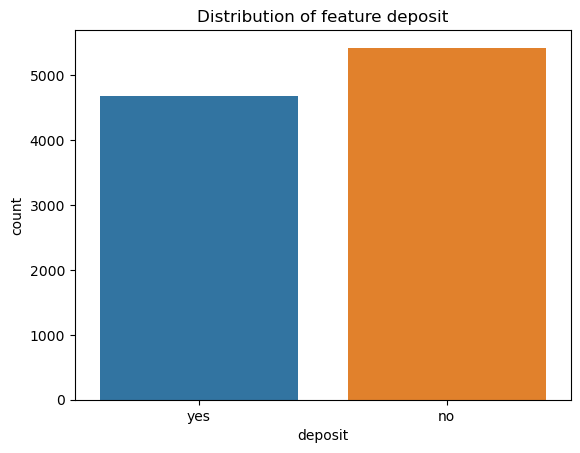

no     5424
yes    4681
Name: deposit, dtype: int64

In [215]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
pl = sns.countplot(x=df['deposit'])
pl.set_title("Distribution of feature deposit")
plt.show()

df.deposit.value_counts()

Целевая переменная недостаточно сбалансирована, требуется стратификация

### Задания 2 и 3

<Figure size 640x480 with 0 Axes>

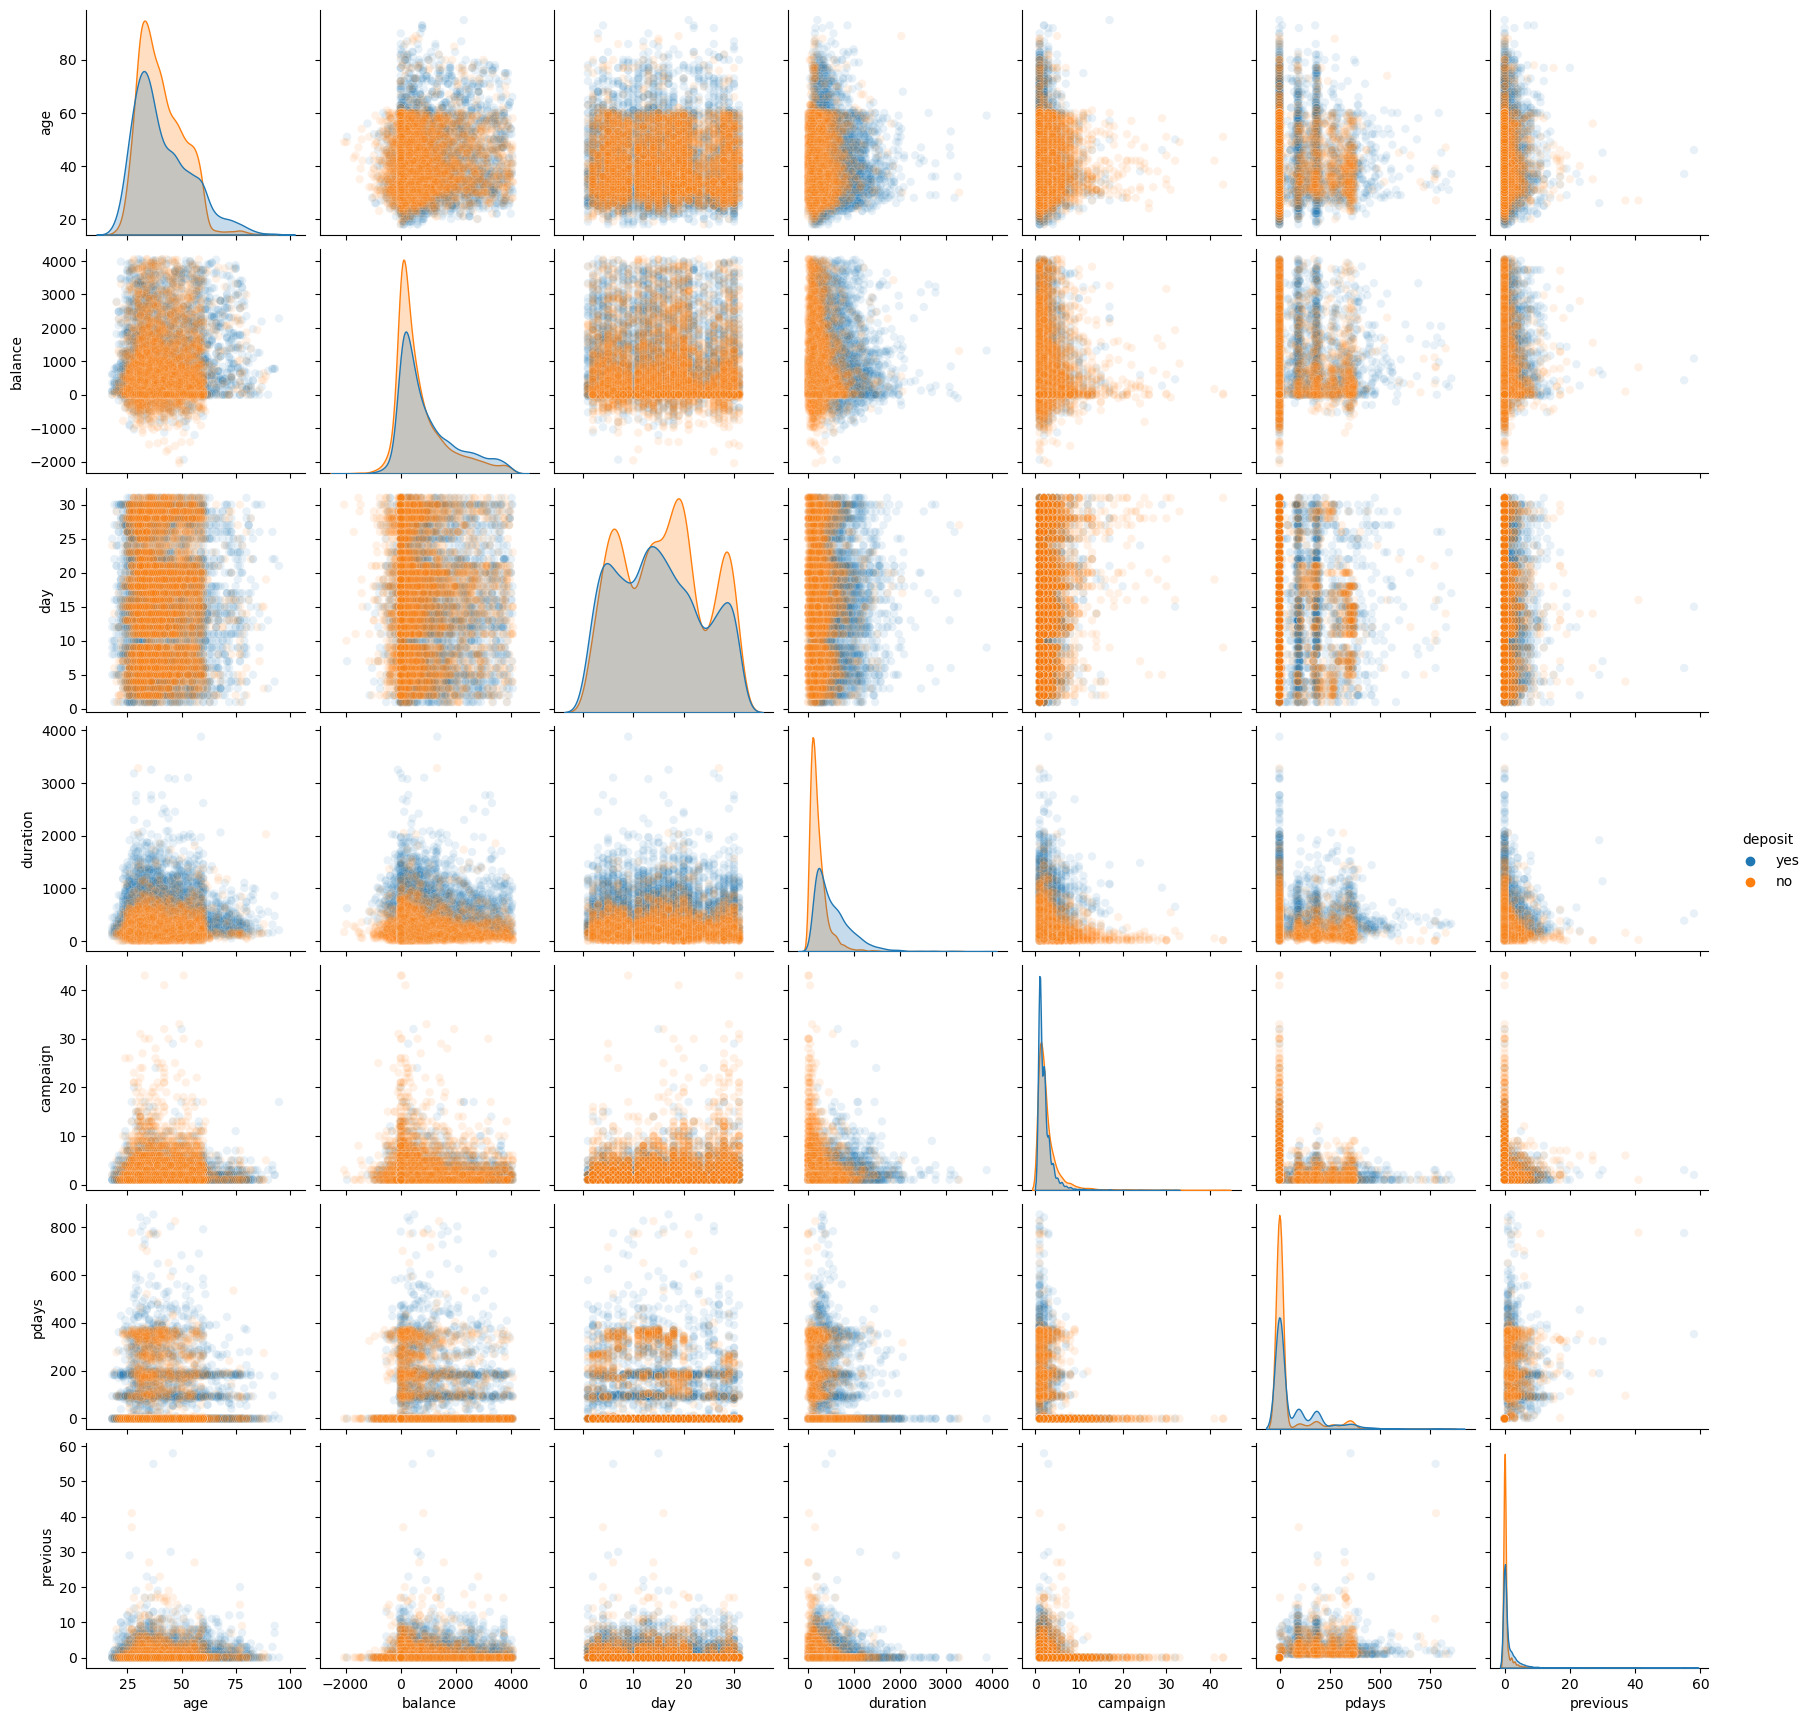

deposit                  no          yes
age      count  5424.000000  4681.000000
         mean     40.629978    41.203162
         std      10.196686    13.291117
         min      18.000000    18.000000
         25%      33.000000    31.000000
         50%      39.000000    38.000000
         75%      48.000000    49.000000
         max      89.000000    95.000000
balance  count  5424.000000  4681.000000
         mean    682.155420   953.071566
         std     934.374340  1040.543075
         min   -2049.000000 -1944.000000
         25%      46.000000   163.000000
         50%     342.000000   569.000000
         75%     992.000000  1495.000000
         max    4063.000000  4060.000000
day      count  5424.000000  4681.000000
         mean     16.036320    15.073489
         std       8.362851     8.503427
         min       1.000000     1.000000
         25%       8.000000     8.000000
         50%      16.000000    15.000000
         75%      22.000000    21.000000
         max      31.000000    31.000000
duration count  5424.000000  4681.000000
         mean    221.316740   539.568896
         std     206.688801   394.408498
         min       2.000000     8.000000
         25%      93.000000   245.000000
         50%     163.000000   429.000000
         75%     278.000000   727.000000
         max    3284.000000  3881.000000
campaign count  5424.000000  4681.000000
         mean      2.845870     2.136296
         std       3.199471     1.921040
         min       1.000000     1.000000
         25%       1.000000     1.000000
         50%       2.000000     2.000000
         75%       3.000000     2.000000
         max      43.000000    32.000000
pdays    count  5424.000000  4681.000000
         mean     36.253872    68.776757
         std      97.527835   119.854999
         min      -1.000000    -1.000000
         25%      -1.000000    -1.000000
         50%      -1.000000    -1.000000
         75%      -1.000000    98.000000
         max     826.000000   854.000000
previous count  5424.000000  4681.000000
         mean      0.522124     1.157018
         std       1.901471     2.542359
         min       0.000000     0.000000
         25%       0.000000     0.000000
         50%       0.000000     0.000000
         75%       0.000000     1.000000
         max      41.000000    58.000000

In [216]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
#pairplot for numeric features
to_plot = df.dtypes[df.dtypes != 'object'].index.tolist()
to_plot.append('deposit')

plt.figure()
sns.pairplot(df[to_plot], hue= 'deposit', plot_kws={'alpha': 0.1})
plt.show()


df.groupby('deposit').describe().T

- Признак age (возраст) распределен нормально, прослеживается четкая тенденция, что после 60 лет, количество клиентов, отказавшихся от депозита, резко сокращается, возможно это вызвано какими-то бонусами, предлагаемыми банком для людей старше 60 (повышенный процент, программа лояльности). Имеет смысл разделить данный признак на категории по периодам лет.

- Признак balance (баланс) имеет пик вблизи 500 долларов, имеются отрицательные значения (вероятно кредиты или овердрафты), в среднем и по медиане, клиенты, согласившиеся на депозит, имеют больше денег на счету. Для нормализации признака можно применить преобразование Йо-Джонсона.

- Признак day (день, в который был последний контакт) имеет три пика гистограммы, так как в данных отсутствуют года, то невозможно выяснить был ли день выходным или будним, но можно преобразовать данный признак в категориальный, который будет показывать в какую декаду месяца был совершен контакт. Идея в том, что клиенты, получившие зарплату или аванс, более склонны к открытию депозита.

- Признак duration (продолжительность контакта в секундах) имеет скошенное к нулю распредение, есть смысл прологарифмировать данный признак. При этом можно отметить, что клиенты, согласившиеся на депозит в среднем и по медиане имеют более длительную продолжительность контакта, что можно объяснить их более заинтересованностью.

- Признак campaign (количество контактов с этим клиентом в течение текущей кампании) также имеет распределение сосредоточенное в своем большинстве в диапозоне до 5 контактов. Есть смысл данный признак перевести в категориальный разбив количество контаков на категории: 1, 2-5, 5-10, 10+.

- Признак pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании) имеет также распределение со средоточением большинства значений в начале диапазона, причем почти 75% - это значения равные -1, видимо характеризующие отсутствие контакта с клиентом (т.к. значение 0 отсутствует). Данный признак есть смысл прологарифмировать, прибавив 2, тогда значения -1 примут значение 0, а остальные значения будут иметь нормальное распредение.

- previous (количество контактов до текущей кампании) также имеет распределение сосредоточенное в своем большинстве в 0. Есть смысл данный признак перевести в категориальный разбив количество контаков на категории: 0, 1, 2-10, 10+.

Все эти преобразования будут произведены на [второй итерации](#итерация-2), после выполнения заданий.


### Задания 4 и 5

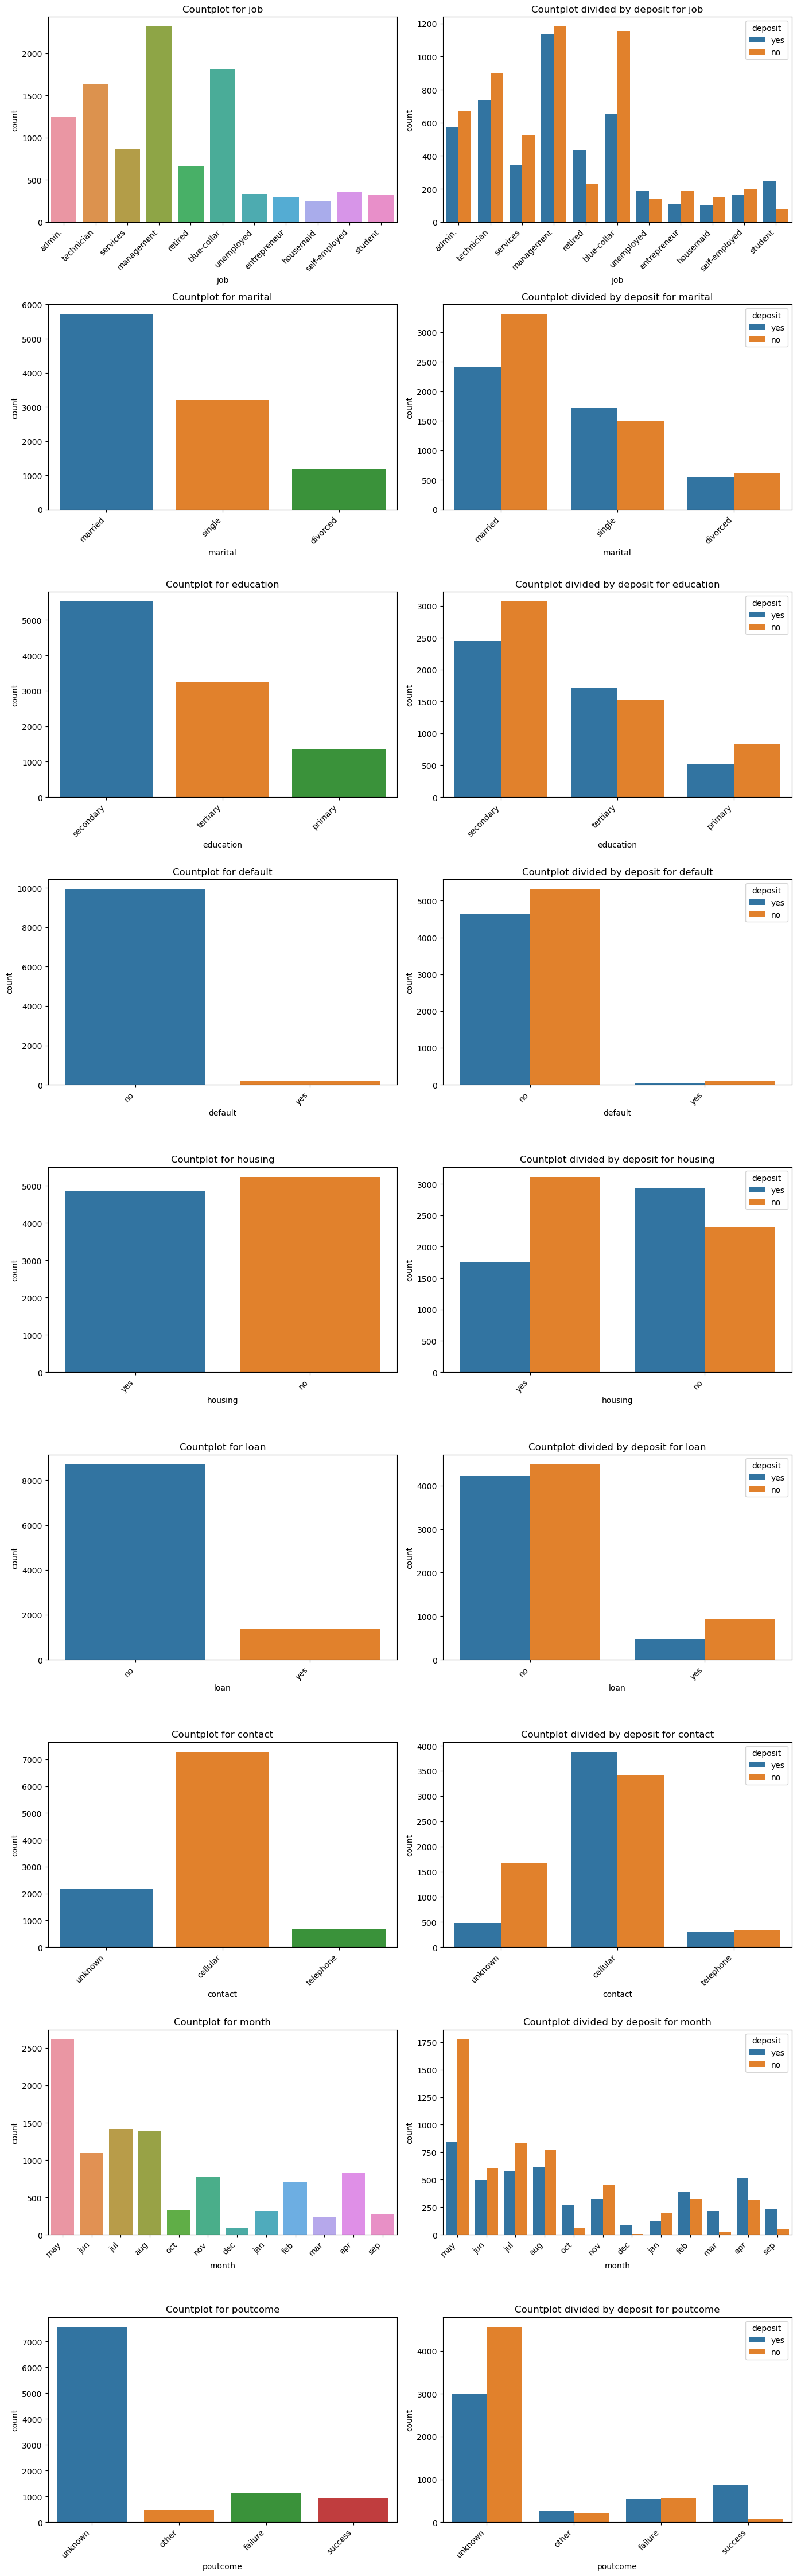

deposit                   no         yes
job       count         5424        4681
          unique          11          11
          top     management  management
          freq          1180        1135
marital   count         5424        4681
          unique           3           3
          top        married     married
          freq          3303        2412
education count         5424        4681
          unique           3           3
          top      secondary   secondary
          freq          3066        2451
default   count         5424        4681
          unique           2           2
          top             no          no
          freq          5310        4629
housing   count         5424        4681
          unique           2           2
          top            yes          no
          freq          3114        2933
loan      count         5424        4681
          unique           2           2
          top             no          no
          freq          4490        4222
contact   count         5424        4681
          unique           3           3
          top       cellular    cellular
          freq          3403        3880
month     count         5424        4681
          unique          12          12
          top            may         may
          freq          1776         841
poutcome  count         5424        4681
          unique           4           4
          top        unknown     unknown
          freq          4562        3008

In [217]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

categorical_features = df.dtypes[df.dtypes == 'object'].index.tolist()
categorical_features.remove('deposit')
num_features = len(categorical_features)


fig, axes = plt.subplots(nrows=num_features, ncols=2, figsize=(14, 5 * num_features))

for i, feature in enumerate(categorical_features):
    # Countplot
    sns.countplot(x=feature, data=df, ax=axes[i, 0])
    axes[i, 0].set_xticklabels(axes[i, 0].get_xticklabels(), rotation=45, ha='right')
    axes[i, 0].set_title(f'Countplot for {feature}')

    # Contplot divided by deposit
    sns.countplot(x=feature, data=df, hue='deposit', ax=axes[i, 1])
    axes[i, 1].set_xticklabels(axes[i, 1].get_xticklabels(), rotation=45, ha='right')
    axes[i, 1].set_title(f'Countplot divided by deposit for {feature}')

plt.tight_layout()
plt.show()


df.groupby('deposit').describe(include='object').T


- Признак job (сфера занятости) имеет 11 категорий (большинство представлено категорией управленцев, голубых воротничков и работников технической сферы), для большинства из них характерна общая картина небольшого преобладания отказывающихся от депозита, однако, стоит отметить, что для категорий студентов, вышедших на пенсию и безработных, преобладает количество согласившихся на депозит. Для пенсионеров и студентов можно предположить, что это следствие каких-то привилегий банка для данных категорий, а безработные возможно имеют большие накопления, на которые живут. Также надо отметить увеличение отказов для голубых воротничков и сферы обслуги, что скорее всего вызвано более низкими зарплатами.

- Признак marital (семейное положение) представлен тремя категориями большинство это замужние/женатые. Категория одиночек имеет превышение в количестве согласившихся на депозит, что можно объяснить меньшими тратами данных клиентов и соответственно большими накоплениями.

- Признак education (уровень образования) представлен тремя категориями большинство - это со средним образованием. Категория клиентов с высшим образованием имеет превышение в количестве согласившихся на депозит, что вероятно вызвано большими по сравнению с другими категориями доходами.

- Признак default (имеется ли просроченный кредит) имеет 2 категории, подавляющие большинство клиентов не имеют просроченного кредита. В разрезе депозита обе категории имеют небольшее превышения в количестве отказавшихся от депозита.

- Признак housing (имеется ли кредит на жильё) также бинарный, количество клиентов с кредитом приближается к количеству клиентов без кредита на жилье, при этом логично, что клиенты, необременнные кредитом чаще соглашаются на депозит, в то время как имеющие кредит на жилье почти в два раза чаще отказываются.

- Признак loan (имеется ли кредит на личные нужды) также бинарный, большинстов клиентов не имеет кредита на личные нужды. В разрезе депозита обе категории имеют  превышения в количестве отказавшихся от депозита, но клиенты, имеющие кредит, чаще отказываются от депозита.

- Признак contact (тип контакта с клиентом) представлен тремя категориями, большинство - это контакт по мобильному телефону(возможно приложение), для данной категории большинство согласившихся, а вот для категории клиентов, с которыми не отмечен какой тип контакта характерно резкое превышение отказов.

- Признак month (месяц, в котором был последний контакт) представлен 12 месяцами, можно отметить, что большинство последних контактов (около 25%) было в мае (вероятно маркетинговая кампания), и для данных клиентов характерен отказ, причем в 2 раза чаще согласия на депозит. Также надо отметить, что положительные решения по депозиту превышают отрицательные в сентябре, октябре, декабре, феврале, марте и апреле, хотя количественные показатели в этих месяцах достаточно малы.  

- Признак poutcome (результат прошлой маркетинговой кампании) имеет 4 категоии, причем 75% выборки - это категория 'unknown'. Для категории 'success' характерно сильное преобладание согласившихся на депозит. Так как нет понимания как интерпритировать категорию 'unknown' и 'other', есть смысл выделить два бинарных признака из данного признака: 'failure' и 'success'.

Преобразования и поиск значений 'unknown' для признаков 'job' и 'education' с помощью логистической регрессии будут произведены на [второй итерации](#итерация-2), после выполнения заданий.

### Задание 6

In [218]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
pd.pivot_table(df, values='age', index='poutcome', columns='deposit', aggfunc='count')

deposit     no   yes
poutcome            
failure    562   547
other      216   265
success     84   861
unknown   4562  3008

### Задание 7

In [219]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
df_month = pd.pivot_table(df, values='age', index='month', columns='deposit', aggfunc='count')
df_month['failure_percent'] = df_month['no'] / (df_month['no'] + df_month['yes'])
df_month.sort_values('failure_percent', ascending=False)

deposit    no  yes  failure_percent
month                              
may      1776  841         0.678640
jan       194  125         0.608150
jul       836  582         0.589563
nov       456  324         0.584615
aug       775  610         0.559567
jun       606  498         0.548913
feb       323  386         0.455571
apr       317  513         0.381928
oct        62  273         0.185075
sep        46  232         0.165468
mar        24  213         0.101266
dec         9   84         0.096774

### Задание 8

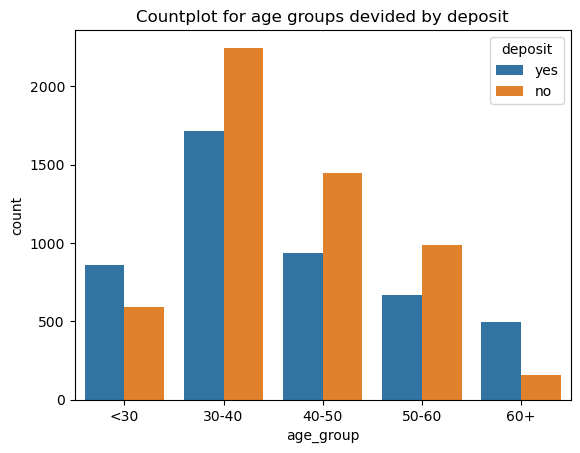

In [220]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
bins = [0, 30, 40, 50, 60, 100]
labels = ['<30', '30-40', '40-50', '50-60', '60+']

df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

countplot = sns.countplot(df, x='age_group', hue='deposit')
countplot.set_title('Countplot for age groups devided by deposit');   

Можно отметить, что большинство клиентов сосредоточено в диапозоне от 30 до 50 лет, для них более характерен отказ от депозита, также как для категории клиентов 50-60 лет; а вот для клиентов младше 30 и старше 60 ситуация обратная, причем, для людей старше 60 количество согласившихся на депозит в 3 раза больше отказавшихся.

### Задание 9

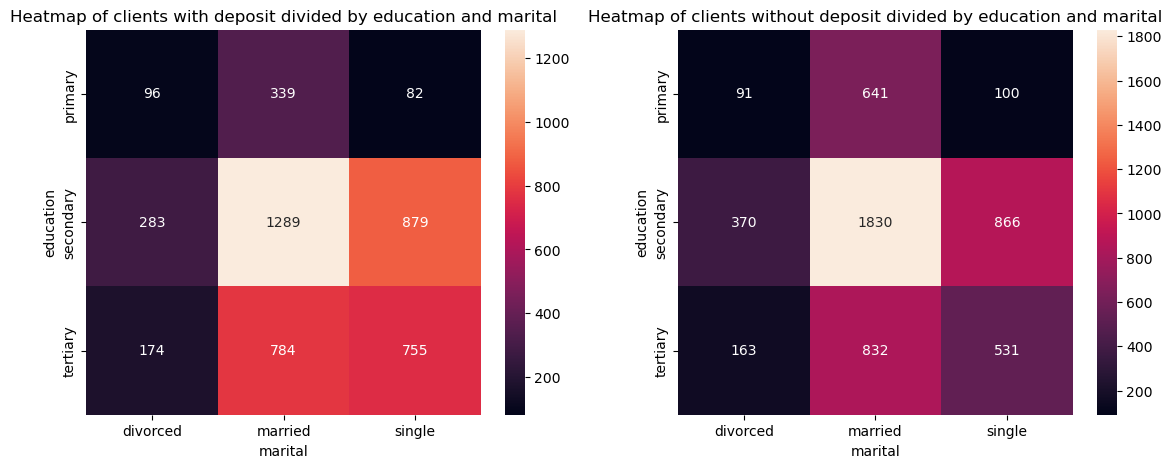

In [221]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
pivot_yes = pd.pivot_table(df[df['deposit'] == 'yes'], values='deposit', index='education', columns='marital', aggfunc='count')
pivot_no= pd.pivot_table(df[df['deposit'] == 'no'], values='deposit', index='education', columns='marital', aggfunc='count')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

sns.heatmap(pivot_yes, annot=True, fmt='.0f', ax=axes[0])
axes[0].set_title(f'Heatmap of clients with deposit divided by education and marital')
sns.heatmap(pivot_no, annot=True, fmt='.0f', ax=axes[1])
axes[1].set_title(f'Heatmap of clients without deposit divided by education and marital')

plt.show()

## Часть 3: преобразование данных

### Задание 1

In [222]:
# преобразуйте уровни образования
LE=LabelEncoder()
df['education'] = LE.fit_transform(df['education'])
df['age_group'] = LE.fit_transform(df['age_group'])

### Задания 2 и 3

In [223]:
# преобразуйте бинарные переменные в представление из нулей и единиц
binary_features = ['deposit', 'default', 'housing', 'loan']

for feature in binary_features:
    df[feature] = df[feature].replace({'yes':1, 'no':0})

### Задание 4

In [224]:
# создайте дамми-переменные
df_dummy = pd.get_dummies(df[['job', 'marital', 'contact', 'month', 'poutcome']])
df_dummy = pd.concat([df, df_dummy], axis=1)
df_dummy = df_dummy.drop(['job', 'marital', 'contact', 'month', 'poutcome'], axis=1)

### Задания 5 и 6

<AxesSubplot: >

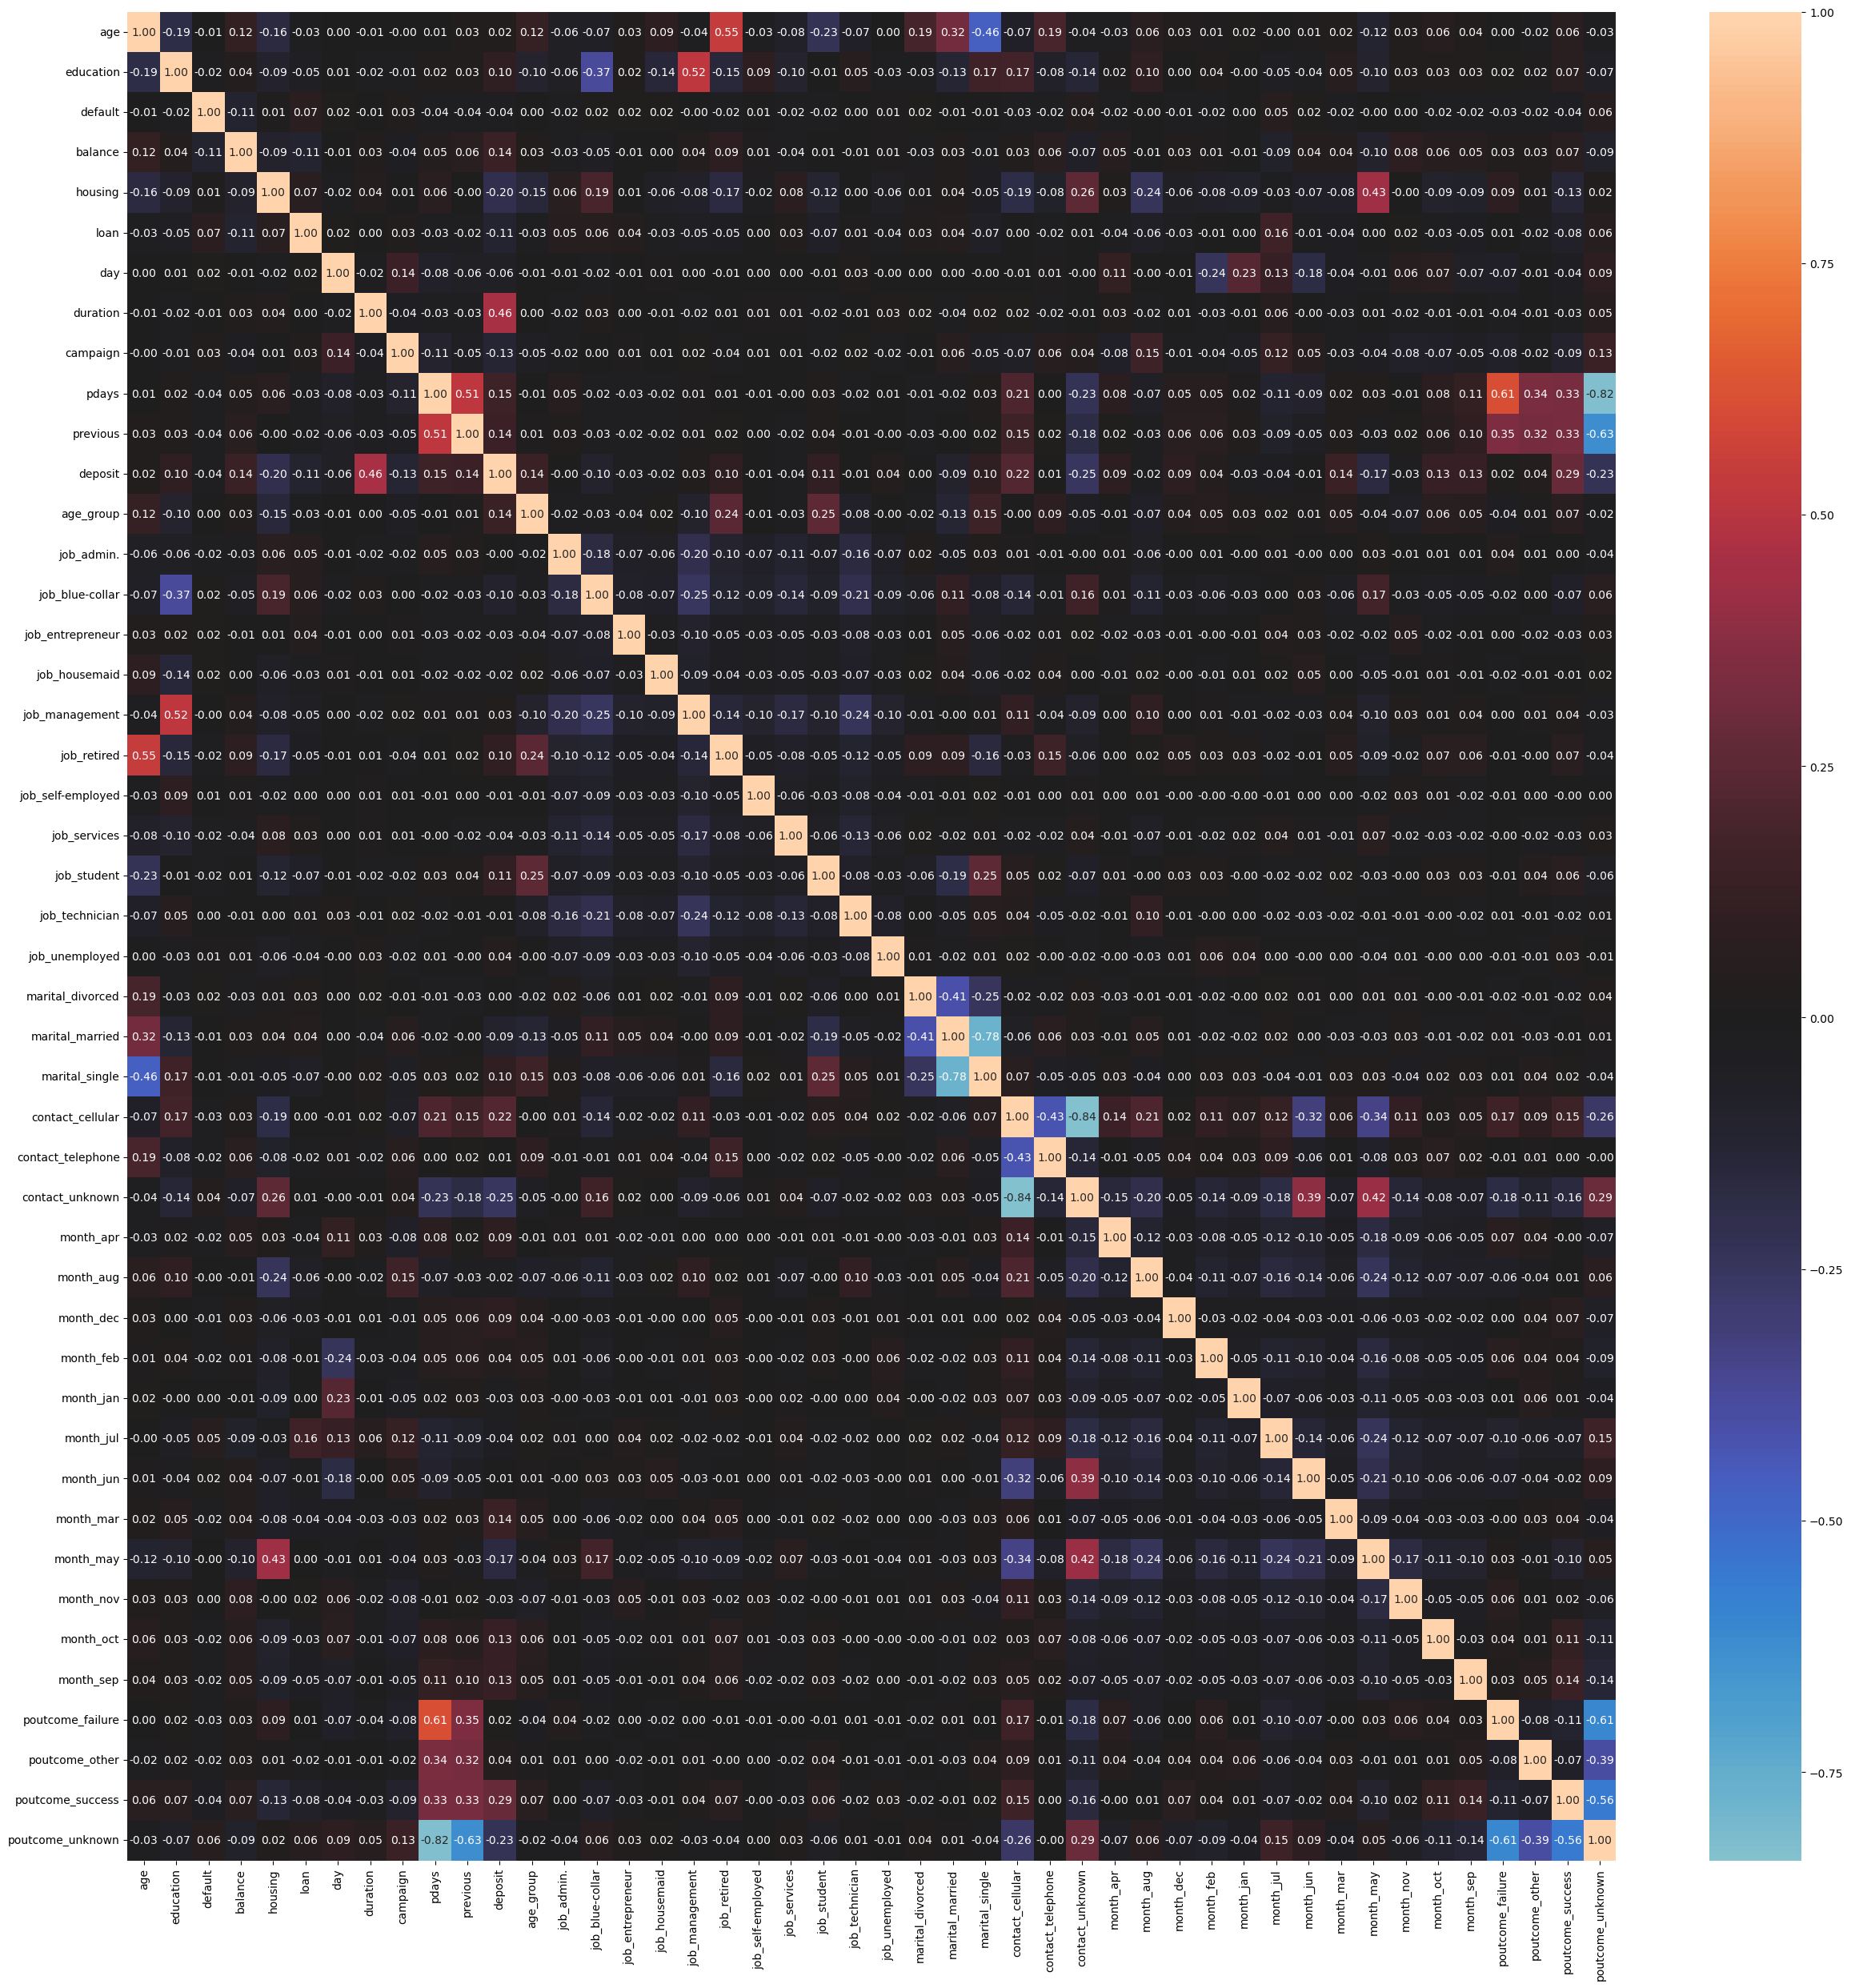

In [225]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.figure(figsize=(30,30))  
sns.heatmap(df_dummy.corr(),fmt='.2f',annot=True, center=0)

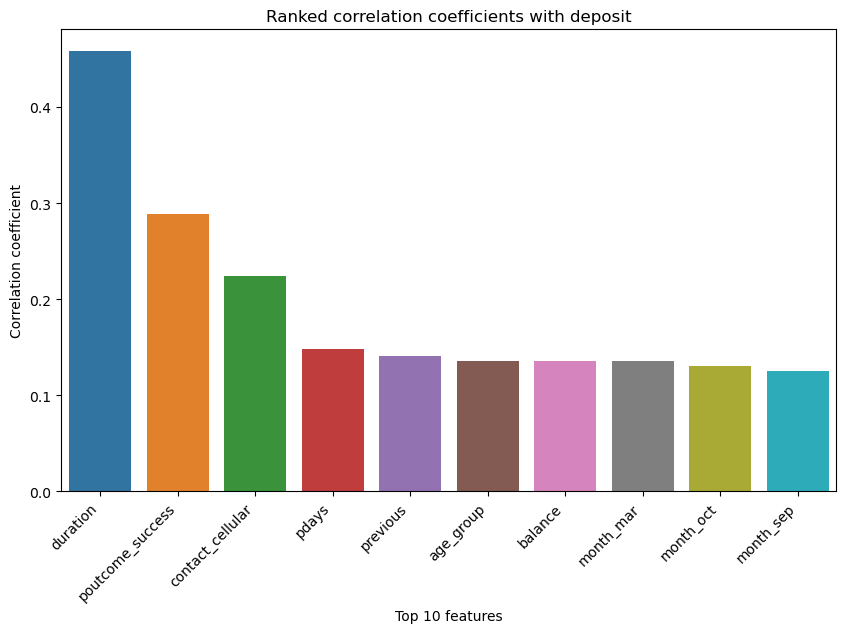

In [226]:
ranked_corr = df_dummy.corr()['deposit'].sort_values(ascending=False)[1:11]

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=ranked_corr.index, y=ranked_corr.values)
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, ha='right')
plt.xlabel('Top 10 features')
plt.ylabel('Correlation coefficient')
plt.title('Ranked correlation coefficients with deposit')
plt.show()

Есть 3 больших коэффициента корреляции для пар признаков 'marital_married' - 'marital_single', 'contact_cellular' - 'contact_unknown', 'poutcome_unkown' - 'pdays'. Коэффициент корреляции Пирсона не превышает 0,85, оставим данные признаки в датафрейме.

Наибольший коэффициент корреляции для признака 'deposit' имеет признак 'duration'.

### Задания 7 и 8

In [229]:
X = df_dummy.drop(['deposit'], axis=1)
y = df_dummy['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [230]:
# рассчитайте необходимые показатели
print(f'Размер обучающей выборки {X_train.shape}')
print(f'Размер тестовой выборки {X_test.shape}')

print(f'Cреднее значение целевой переменной на обучающей выборке {round(y_train.mean(), 2)}')
print(f'Cреднее значение целевой переменной на тестовой выборке {round(y_test.mean(), 2)}')

Размер обучающей выборки (6770, 45)
Размер тестовой выборки (3335, 45)
Cреднее значение целевой переменной на обучающей выборке 0.46
Cреднее значение целевой переменной на тестовой выборке 0.46


### Задание 9

In [231]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)

print(selector.get_feature_names_out())

X_train = X_train[selector.get_feature_names_out()]
X_test = X_test[selector.get_feature_names_out()]

['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous' 'age_group'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']


### Задание 10

In [232]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [233]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

print(f'for Train: \n{classification_report(y_train, y_train_pred)}')
print(f'for Test: \n{classification_report(y_test, y_test_pred)}')


for Train: 
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

for Test: 
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



### Задания 2,3,4

In [234]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(criterion = 'entropy', random_state=42)
dt.fit(X_train, y_train)
 
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

print(f'for Train: \n{classification_report(y_train, y_train_pred)}')
print(f'for Test: \n{classification_report(y_test, y_test_pred)}')

for Train: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

for Test: 
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1790
           1       0.74      0.71      0.72      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.74      0.75      3335
weighted avg       0.75      0.75      0.75      3335



Модель логистической регрессии без регуляризации показала метрику accuracy 0.80 и 0,78 f1 метрику для класса 1. При этом переобучение не выявлено. Модель решающего дерева без ограничений показала большое переобучение, необходимо найти оптимальную глубину для модели.

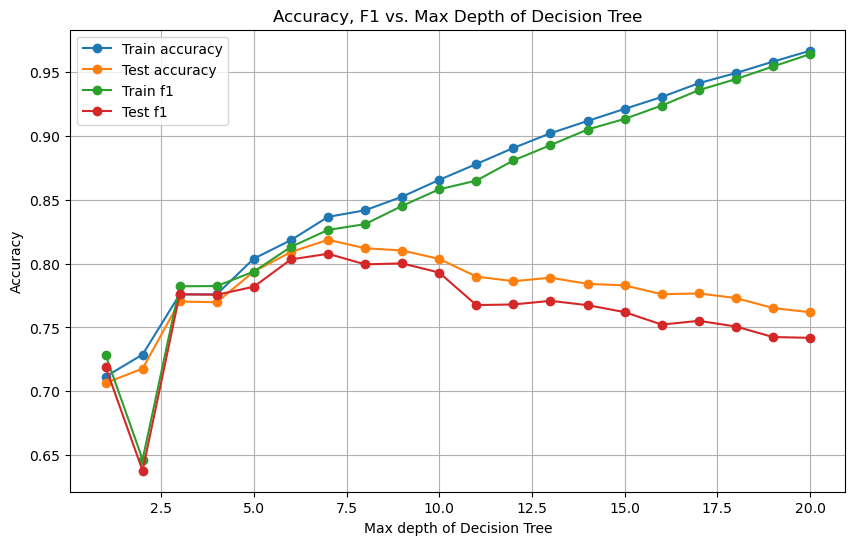

In [236]:
# Построение графиков зависимости метрики accuracy от максимальной глубины дерева решений
train_accuracies = []
test_accuracies = []
train_f1_list = []
test_f1_list = []
metrics.f1_score(y_train, dt.predict(X_train))

max_depths = range(1, 21)

for max_depth in max_depths:
    
    dt = tree.DecisionTreeClassifier(max_depth=max_depth, criterion = 'entropy', random_state=42)
    dt.fit(X_train, y_train)
    
    y_train_pred = dt.predict(X_train)
    train_accuracy = metrics.accuracy_score(y_train, y_train_pred)
    train_f1 = metrics.f1_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)
    train_f1_list.append(train_f1)
    
    y_test_pred = dt.predict(X_test)
    test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
    test_f1 = metrics.f1_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)
    test_f1_list.append(test_f1)


plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_accuracies, label='Train accuracy', marker='o')
plt.plot(max_depths, test_accuracies, label='Test accuracy', marker='o')
plt.plot(max_depths, train_f1_list, label='Train f1', marker='o')
plt.plot(max_depths, test_f1_list, label='Test f1', marker='o')
plt.xlabel('Max depth of Decision Tree')
plt.ylabel('Accuracy, F1')
plt.title('Accuracy, F1 vs. Max Depth of Decision Tree')
plt.legend()
plt.grid(True)
plt.show()

In [239]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(criterion = 'entropy', random_state=42, max_depth=7)
dt.fit(X_train, y_train)
 
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

print(f'for Train: \n{classification_report(y_train, y_train_pred)}')
print(f'for Test: \n{classification_report(y_test, y_test_pred)}')

for Train: 
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      3634
           1       0.81      0.84      0.83      3136

    accuracy                           0.84      6770
   macro avg       0.84      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770

for Test: 
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.79      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



Модель решающего дерева с глубиной 7 улучшила метрики: accuracy = 0.82 и f1-метрика для класса 1 = 0,81.

### Задание 5

In [240]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth': [3, 5, 7]
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  

grid_search_tree.fit(X_train, y_train) 
print(f'accuracy на тестовом наборе: {grid_search_tree.score(X_test, y_test)}')
y_test_pred = grid_search_tree.predict(X_test)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred)}')
print(f'Наилучшие значения гиперпараметров: {grid_search_tree.best_params_}')

accuracy на тестовом наборе: 0.8140929535232384
f1_score на тестовом наборе: 0.8019169329073482
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


Подобранные с помощью GridSearch параметры решающего дерева не улучшили метрики.

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [241]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(random_state=42,
                                     n_estimators = 100,
                                     criterion = 'gini',
                                     min_samples_leaf = 5,
                                     max_depth = 10
                                     )

rf.fit(X_train, y_train)
 
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print(f'for Train: \n{classification_report(y_train, y_train_pred)}')
print(f'for Test: \n{classification_report(y_test, y_test_pred)}')

for Train: 
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3634
           1       0.84      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

for Test: 
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [242]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    learning_rate = 0.05, 
    n_estimators=300,
    max_depth=5,
    min_samples_leaf=5,
    random_state=42 
)
gb.fit(X_train, y_train)

y_train_pred = gb.predict(X_train)
y_test_pred = gb.predict(X_test)

print(f'for Train: \n{classification_report(y_train, y_train_pred)}')
print(f'for Test: \n{classification_report(y_test, y_test_pred)}')

for Train: 
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3634
           1       0.87      0.89      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770

for Test: 
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [243]:
# объедините уже известные вам алгоритмы с помощью стекинга 
from sklearn.ensemble import StackingClassifier


estimators = [
    ('dt',  dt),
    ('gb',  gb)
]

reg = StackingClassifier(
    estimators=estimators,
    final_estimator=log_reg
)
reg.fit(X_train, y_train)

y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

print(f'for Train: \n{classification_report(y_train, y_train_pred)}')
print(f'for Test: \n{classification_report(y_test, y_test_pred)}')

for Train: 
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      3634
           1       0.87      0.88      0.87      3136

    accuracy                           0.88      6770
   macro avg       0.88      0.88      0.88      6770
weighted avg       0.88      0.88      0.88      6770

for Test: 
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1790
           1       0.81      0.82      0.81      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Модели случайного леса и градиентного бустинга дали лучший результат accuracy = 0.83, f1-метрика для класса 1 = 0,82 и f1-метрика для класса 0 = 0,84, но модель случайного леса была менее переобучена и дала менее ресурснозатратный результат (по времени), попробуем оптимизировать гиперпараметры для модели случайного леса.

Модель стекинга дала чуть худший результат accuracy = 0.83, f1-метрика для класса 1 = 0,81 и f1-метрика для класса 0 = 0,84

### Задание 5

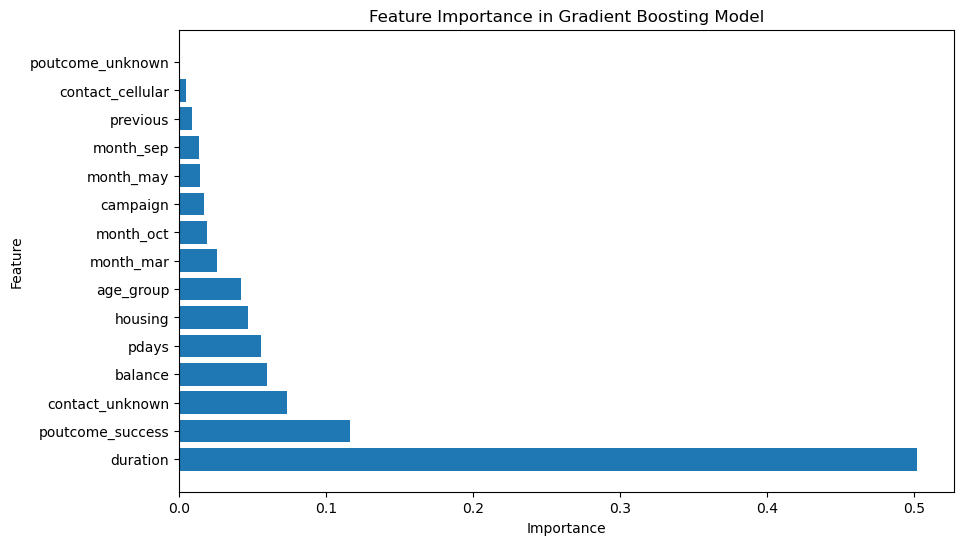

             Feature  Importance
2           duration    0.501987
13  poutcome_success    0.116264
8    contact_unknown    0.073762
0            balance    0.059764
4              pdays    0.055647
1            housing    0.046583
6          age_group    0.042102
9          month_mar    0.026144
11         month_oct    0.018824
3           campaign    0.017101
10         month_may    0.014508
12         month_sep    0.013428
5           previous    0.008901
7   contact_cellular    0.004600
14  poutcome_unknown    0.000386


In [244]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
feature_importances = gb.feature_importances_

importance_df = pd.DataFrame({
    'Feature': selector.get_feature_names_out(),
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Построение графика
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Gradient Boosting Model')
#plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

print(importance_df)

### Задания 6,7,8

In [245]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score
  

In [246]:
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=40)

[I 2024-06-06 19:31:23,189] A new study created in memory with name: RandomForestClassifier
[I 2024-06-06 19:31:27,556] Trial 0 finished with value: 0.8551767281826711 and parameters: {'n_estimators': 175, 'max_depth': 12, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8551767281826711.
[I 2024-06-06 19:31:31,774] Trial 1 finished with value: 0.8480853735091023 and parameters: {'n_estimators': 174, 'max_depth': 14, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8551767281826711.
[I 2024-06-06 19:31:35,675] Trial 2 finished with value: 0.8570535853772847 and parameters: {'n_estimators': 175, 'max_depth': 20, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.8570535853772847.
[I 2024-06-06 19:31:38,592] Trial 3 finished with value: 0.8538798498122653 and parameters: {'n_estimators': 143, 'max_depth': 27, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.8570535853772847.
[I 2024-06-06 19:31:41,682] Trial 4 finished with value: 0.8452830188679246 and parameters: {'n_

In [247]:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'for Train: \n{classification_report(y_train, y_train_pred)}')
print(f'for Test: \n{classification_report(y_test, y_test_pred)}')

for Train: 
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      3634
           1       0.91      0.94      0.93      3136

    accuracy                           0.93      6770
   macro avg       0.93      0.93      0.93      6770
weighted avg       0.93      0.93      0.93      6770

for Test: 
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1790
           1       0.79      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.82      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



После подбора гиперпараметров с помощью Optuna модель случайного леса дала такой же результат в метриках accuracy = 0.83, f1-метрика для класса 1 = 0,82 и f1-метрика для класса 0 = 0,83.

Так как F1-метрика была показана на одинаковом уровне (0,82) на всех рассматриваемых моделях кроме стекинга, но переобучение не было выявлено только на модели случайного леса. Также модель случайного  леса была наименее ресурснозатратна. Для улучшения метрики попробуем провести новое преобразование и отбор признаков и построить модель случайного леса, оптимизируя параметры с помощью Optuna и используя кросс-валидацию.

__________

### Итерация 2

In [248]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [249]:
# удалим 25 пропусков
df = df.dropna(axis=0)

In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11137 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11137 non-null  int64 
 1   job        11137 non-null  object
 2   marital    11137 non-null  object
 3   education  11137 non-null  object
 4   default    11137 non-null  object
 5   balance    11137 non-null  object
 6   housing    11137 non-null  object
 7   loan       11137 non-null  object
 8   contact    11137 non-null  object
 9   day        11137 non-null  int64 
 10  month      11137 non-null  object
 11  duration   11137 non-null  int64 
 12  campaign   11137 non-null  int64 
 13  pdays      11137 non-null  int64 
 14  previous   11137 non-null  int64 
 15  poutcome   11137 non-null  object
 16  deposit    11137 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.5+ MB


Преобразования данных

In [251]:
#age
bins = [0, 30, 40, 50, 60, 100]
labels = ['<30', '30-40', '40-50', '50-60', '60+']

df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

df_dummy = pd.get_dummies(df['age_group'])
df = pd.concat([df, df_dummy], axis=1)
df = df.drop(['age_group', 'age'], axis=1)

In [252]:
#job
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Разделение данных на две части
df_known = df[df['job'] != 'unknown']
df_unknown = df[df['job'] == 'unknown']
# Выделение признаков и целевой переменной
X_known = df_known.drop(columns=['job'])
y_known = df_known['job']
X_unknown = df_unknown.drop(columns=['job'])
# Выявление категориальных и числовых признаков
categorical_features = X_known.select_dtypes(include=['object']).columns
numeric_features = X_known.select_dtypes(include=['number']).columns
# Создание трансформера для обработки категориальных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', linear_model.LogisticRegression(max_iter=1000))
])
pipeline.fit(X_known, y_known)
predicted_jobs = pipeline.predict(X_unknown)

df.loc[df['job'] == 'unknown', 'job'] = predicted_jobs
df['job'].value_counts()

management       2587
blue-collar      1948
technician       1834
admin.           1337
services          920
retired           786
self-employed     405
student           361
unemployed        357
entrepreneur      328
housemaid         274
Name: job, dtype: int64

In [253]:
df_dummy = pd.get_dummies(df['job'])
df = pd.concat([df, df_dummy], axis=1)
df = df.drop('job', axis=1)

In [254]:
#marital
df_dummy = pd.get_dummies(df['marital'])
df = pd.concat([df, df_dummy], axis=1)
df = df.drop('marital', axis=1)

In [255]:
#education
# Разделение данных на две части
df_known = df[df['education'] != 'unknown']
df_unknown = df[df['education'] == 'unknown']
# Выделение признаков и целевой переменной
X_known = df_known.drop(columns=['education'])
y_known = df_known['education']
X_unknown = df_unknown.drop(columns=['education'])
# Выявление категориальных и числовых признаков
categorical_features = X_known.select_dtypes(include=['object']).columns
numeric_features = X_known.select_dtypes(include=['number']).columns
# Создание трансформера для обработки категориальных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', linear_model.LogisticRegression(max_iter=1000))
])
pipeline.fit(X_known, y_known)
predicted = pipeline.predict(X_unknown)

df.loc[df['education'] == 'unknown', 'education'] = predicted
df['education'].value_counts()

secondary    5763
tertiary     3798
primary      1576
Name: education, dtype: int64

In [256]:
df['education'] = df['education'].replace({'primary':1, 'secondary':2,'tertiary':3})

In [257]:
#default
df['default'] = df['default'].replace({'yes':1, 'no':0})

In [258]:
#balance
df['balance'] = df['balance'].apply(lambda x: float(''.join(x.replace(',','.').strip()[:-1].split())))

outliers, df, lower_bound, upper_bound = outliers_iqr(df, 'balance', left=1, right=2.5)
print(f'Верхняя граница по методу Тьюки: {upper_bound}, нижняя граница по методу Тьюки: {lower_bound}')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df.shape[0]}')

Верхняя граница по методу Тьюки: 5670.5, нижняя граница по методу Тьюки: -1462.0
Число выбросов по методу Тьюки: 637
Результирующее число записей: 10500


In [259]:
# Преобразование Йо-Джонсона
pt_yeo = preprocessing.PowerTransformer(method='yeo-johnson')
df['balance'] = pt_yeo.fit_transform(df[['balance']])

In [260]:
# housing, loan and deposit
binary_features = [ 'housing', 'loan', 'deposit']

for feature in binary_features:
    df[feature] = df[feature].replace({'yes':1, 'no':0})

In [261]:
#contact
df_dummy = pd.get_dummies(df['contact'])
df = pd.concat([df, df_dummy], axis=1)
df = df.drop('contact', axis=1)

In [262]:
# day
bins = [0, 11, 21, 32]
labels = ['decade_1', 'decade_2', 'decade_3']

df['day'] = pd.cut(df['day'], bins=bins, labels=labels, right=False)

df_dummy = pd.get_dummies(df['day'])
df = pd.concat([df, df_dummy], axis=1)
df = df.drop('day', axis=1)

In [263]:
#month
df_dummy = pd.get_dummies(df['month'])
df = pd.concat([df, df_dummy], axis=1)
df = df.drop('month', axis=1)

<AxesSubplot: >

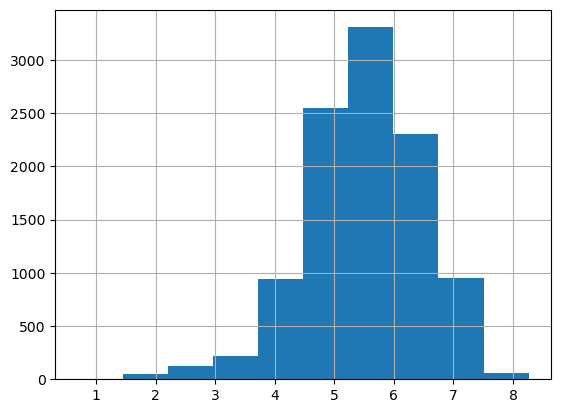

In [264]:
#duration
df['duration'] = np.log(df['duration'])
df.duration.hist()

In [265]:
#campaign
bins = [0, 1, 5, 10, 100]
labels = [1, 2, 3, 4]

df['campaign'] = pd.cut(df['campaign'], bins=bins, labels=labels, right=True)

<AxesSubplot: >

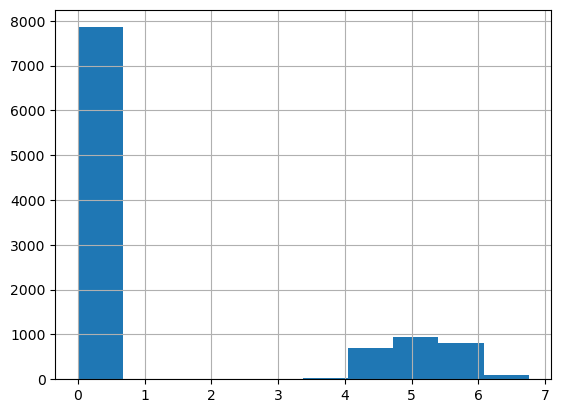

In [266]:
#pdays 
df['pdays'] = np.log(df['pdays']+2)
df.pdays.hist()

In [267]:
#previous
bins = [0, 1, 2, 10, 100]
labels = [0, 1, 2, 3]

df['previous'] = pd.cut(df['previous'], bins=bins, labels=labels, right=False)

In [268]:
#poutcome
df['poutcome_success'] = df['poutcome'].apply(lambda x: 1 if x=='success' else 0)
df['poutcome_failure'] = df['poutcome'].apply(lambda x: 1 if x=='failure' else 0)

df = df.drop('poutcome', axis=1)

<AxesSubplot: >

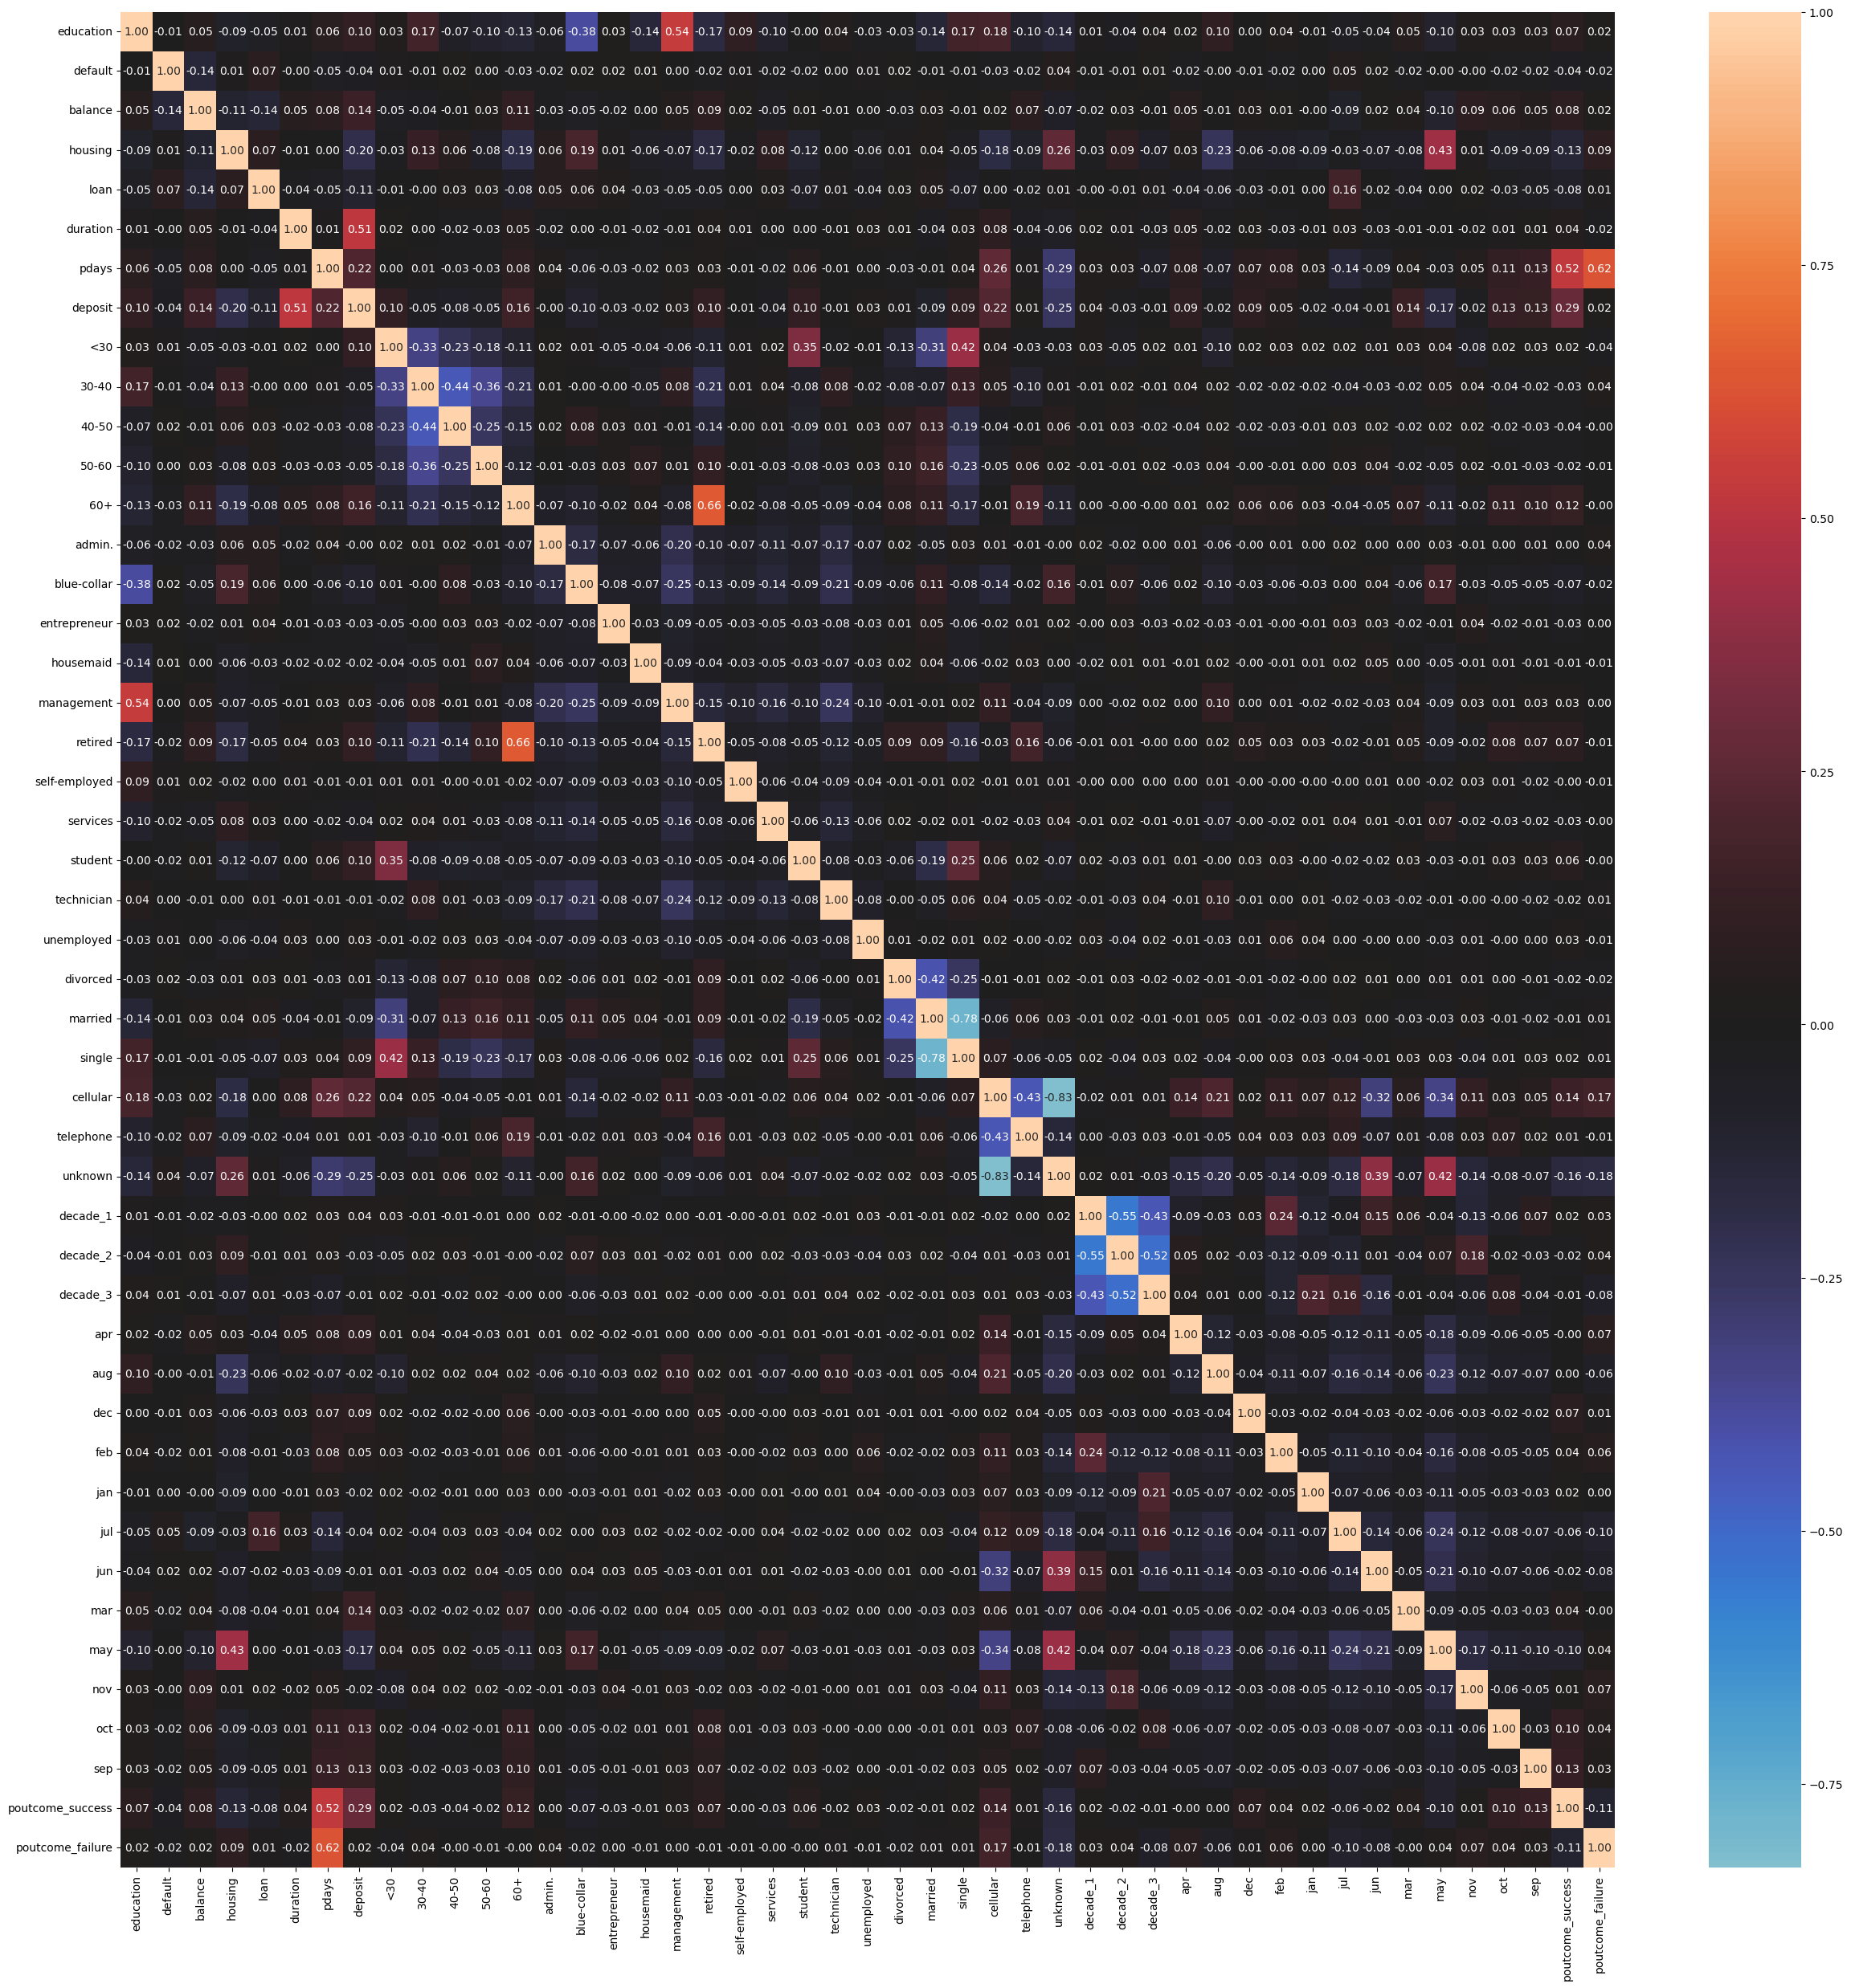

In [269]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.figure(figsize=(30,30))  
sns.heatmap(df.corr(),fmt='.2f',annot=True, center=0)

Коэффициенты корреляции более 0,85 не выявлены, оставляем все признаки

In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10500 entries, 0 to 11161
Data columns (total 49 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   education         10500 non-null  int64   
 1   default           10500 non-null  int64   
 2   balance           10500 non-null  float64 
 3   housing           10500 non-null  int64   
 4   loan              10500 non-null  int64   
 5   duration          10500 non-null  float64 
 6   campaign          10500 non-null  category
 7   pdays             10500 non-null  float64 
 8   previous          10500 non-null  category
 9   deposit           10500 non-null  int64   
 10  <30               10500 non-null  uint8   
 11  30-40             10500 non-null  uint8   
 12  40-50             10500 non-null  uint8   
 13  50-60             10500 non-null  uint8   
 14  60+               10500 non-null  uint8   
 15  admin.            10500 non-null  uint8   
 16  blue-collar       1050

In [271]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [272]:
# с помощью SelectKBest отберите 30 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=30)
selector.fit(X_train, y_train)

print(selector.get_feature_names_out())

X_train = X_train[selector.get_feature_names_out()]
X_test = X_test[selector.get_feature_names_out()]

['education' 'balance' 'housing' 'loan' 'duration' 'campaign' 'pdays'
 'previous' '<30' '30-40' '40-50' '50-60' '60+' 'blue-collar' 'retired'
 'student' 'unemployed' 'married' 'single' 'cellular' 'unknown' 'decade_1'
 'apr' 'dec' 'jul' 'mar' 'may' 'oct' 'sep' 'poutcome_success']


In [274]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
from sklearn.model_selection import cross_val_score

def optuna_rf(trial):
  """This function optimizes the hyperparameters of a RandomForestClassifier using the Optuna library. 
  This function is intended to be used within the Optuna optimization process to find the best hyperparameter values 
  for the random forest classifier with the goal of maximizing the F1 score."""
  # задаем пространства поиска гиперпараметров
  n_estimators = n_estimators = trial.suggest_int('n_estimators', 100, 300, 1)
  max_depth = trial.suggest_int('max_depth', 10, 35, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

In [275]:
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=25)

[I 2024-06-06 19:39:14,637] A new study created in memory with name: RandomForestClassifier
[I 2024-06-06 19:39:41,304] Trial 0 finished with value: 0.831389519312531 and parameters: {'n_estimators': 291, 'max_depth': 30, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.831389519312531.
[I 2024-06-06 19:39:51,465] Trial 1 finished with value: 0.8342468934713452 and parameters: {'n_estimators': 147, 'max_depth': 28, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8342468934713452.
[I 2024-06-06 19:40:06,336] Trial 2 finished with value: 0.8331184169543127 and parameters: {'n_estimators': 192, 'max_depth': 32, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8342468934713452.
[I 2024-06-06 19:40:24,598] Trial 3 finished with value: 0.8318551198260147 and parameters: {'n_estimators': 284, 'max_depth': 20, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8342468934713452.
[I 2024-06-06 19:40:39,844] Trial 4 finished with value: 0.8311518086423881 and parameters: {'n_es

In [276]:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'for Test: \n{classification_report(y_test, y_test_pred)}')

for Test: 
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1838
           1       0.80      0.87      0.83      1627

    accuracy                           0.84      3465
   macro avg       0.84      0.84      0.84      3465
weighted avg       0.84      0.84      0.84      3465



После нового преобразования признаков, отбора 30 признаков, подбора гиперпараметров на кросс-валидации по 5 фолдам для модели случайного леса были улучшены метрики: accuracy = 0.84, f1-метрика для класса 1 = 0,83 и f1-метрика для класса 0 = 0,84. 

Попробуем провести преобразование данных с помощью Minmaxsxaler

______

### Итерация 3

Добавим нормализацию данных с помощью Minmaxsxaler

In [277]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [278]:
# с помощью SelectKBest отберите 30 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=30)
selector.fit(X_train, y_train)

print(selector.get_feature_names_out())

X_train = X_train[selector.get_feature_names_out()]
X_test = X_test[selector.get_feature_names_out()]

['education' 'balance' 'housing' 'loan' 'duration' 'campaign' 'pdays'
 'previous' '<30' '30-40' '40-50' '50-60' '60+' 'blue-collar' 'retired'
 'student' 'unemployed' 'married' 'single' 'cellular' 'unknown' 'decade_1'
 'apr' 'dec' 'jul' 'mar' 'may' 'oct' 'sep' 'poutcome_success']


In [279]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [280]:
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=25)

[I 2024-06-06 19:46:11,684] A new study created in memory with name: RandomForestClassifier
[I 2024-06-06 19:46:20,129] Trial 0 finished with value: 0.8311102322731531 and parameters: {'n_estimators': 120, 'max_depth': 24, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8311102322731531.
[I 2024-06-06 19:46:29,165] Trial 1 finished with value: 0.827888424668392 and parameters: {'n_estimators': 136, 'max_depth': 25, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8311102322731531.
[I 2024-06-06 19:46:45,256] Trial 2 finished with value: 0.8326100140153748 and parameters: {'n_estimators': 213, 'max_depth': 16, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8326100140153748.
[I 2024-06-06 19:47:01,510] Trial 3 finished with value: 0.8290472550257659 and parameters: {'n_estimators': 274, 'max_depth': 21, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.8326100140153748.
[I 2024-06-06 19:47:10,361] Trial 4 finished with value: 0.8309641983698081 and parameters: {'n

In [281]:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'for Test: \n{classification_report(y_test, y_test_pred)}')

for Test: 
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1838
           1       0.80      0.87      0.84      1627

    accuracy                           0.84      3465
   macro avg       0.84      0.84      0.84      3465
weighted avg       0.84      0.84      0.84      3465



метрики были еще улучшены: accuracy = 0.84, f1-метрика для класса 1 = 0,84 и f1-метрика для класса 0 = 0,84. 

___________

### Итерация 4

Попробуем построить модель, которая также будет учитывать пары признаков, например месяц и декада месяц. Для этого преобразуем данные с помощю PolynomialFeatures(degree=2, interaction_only=True), убрав квадраты признаков

In [282]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']

# Создание датафрейма с попарными признаками с помощью PolynomialFeatures
poly = preprocessing.PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform(X)
poly_feature_names = poly.get_feature_names_out(input_features=X.columns)

X_poly = pd.DataFrame(poly_features, columns=poly_feature_names)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, stratify=y, random_state = 42, test_size = 0.33)

In [283]:
# с помощью SelectKBest отберите 30 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=30)
selector.fit(X_train, y_train)

print(selector.get_feature_names_out())

X_train = X_train[selector.get_feature_names_out()]
X_test = X_test[selector.get_feature_names_out()]

['duration' 'pdays' 'previous' 'cellular' 'unknown' 'poutcome_success'
 'education duration' 'education pdays' 'education previous'
 'education cellular' 'education unknown' 'education poutcome_success'
 'housing campaign' 'housing unknown' 'duration pdays' 'duration previous'
 'duration cellular' 'duration unknown' 'duration poutcome_success'
 'campaign unknown' 'campaign poutcome_success' 'pdays previous'
 'pdays cellular' 'pdays poutcome_success' 'previous cellular'
 'previous poutcome_success' 'married unknown' 'married poutcome_success'
 'cellular poutcome_success' 'unknown may']


In [284]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [285]:
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=25)

[I 2024-06-06 19:52:27,585] A new study created in memory with name: RandomForestClassifier
[I 2024-06-06 19:52:50,083] Trial 0 finished with value: 0.7860734855339171 and parameters: {'n_estimators': 220, 'max_depth': 35, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.7860734855339171.
[I 2024-06-06 19:53:01,199] Trial 1 finished with value: 0.7881874588168254 and parameters: {'n_estimators': 146, 'max_depth': 33, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.7881874588168254.
[I 2024-06-06 19:53:22,408] Trial 2 finished with value: 0.7850485280277353 and parameters: {'n_estimators': 243, 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.7881874588168254.
[I 2024-06-06 19:53:32,072] Trial 3 finished with value: 0.7812183524951545 and parameters: {'n_estimators': 106, 'max_depth': 29, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.7881874588168254.
[I 2024-06-06 19:53:45,750] Trial 4 finished with value: 0.7732218818925473 and parameters: {'n

In [286]:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'for Test: \n{classification_report(y_test, y_test_pred)}')

for Test: 
              precision    recall  f1-score   support

           0       0.82      0.79      0.81      1838
           1       0.77      0.80      0.79      1627

    accuracy                           0.80      3465
   macro avg       0.80      0.80      0.80      3465
weighted avg       0.80      0.80      0.80      3465



Данное преобразование дало значительное ухудшения результата в метриках.

____________________

**Вывод:**

Лушие метрики: ***accuracy = 0.84, f1-метрика для класса 1 = 0,84, f1-метрика для класса 0 = 0,84***.

Лучшая модель: случайный лес с нормализацией minmaxsxaler и гиперпараметрами (итерация 3):
*'n_estimators': 159, 'max_depth': 18, 'min_samples_leaf': 2*